In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from numba import njit

import itertools
import pandas as pd


plt.style.use('seaborn-v0_8-whitegrid')
# Global Configuration (Defaults)
NX = 81
NY = 81
OUTPUT_DIR = "simulation_results"

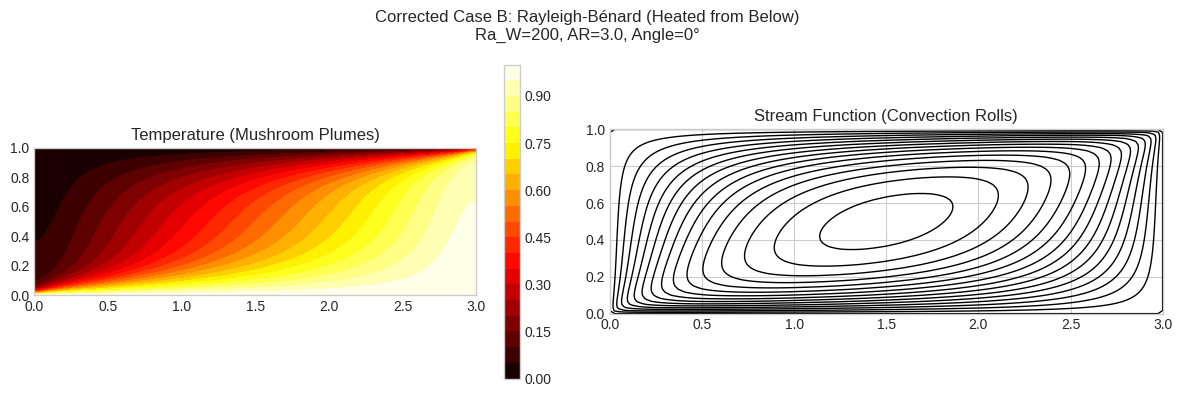

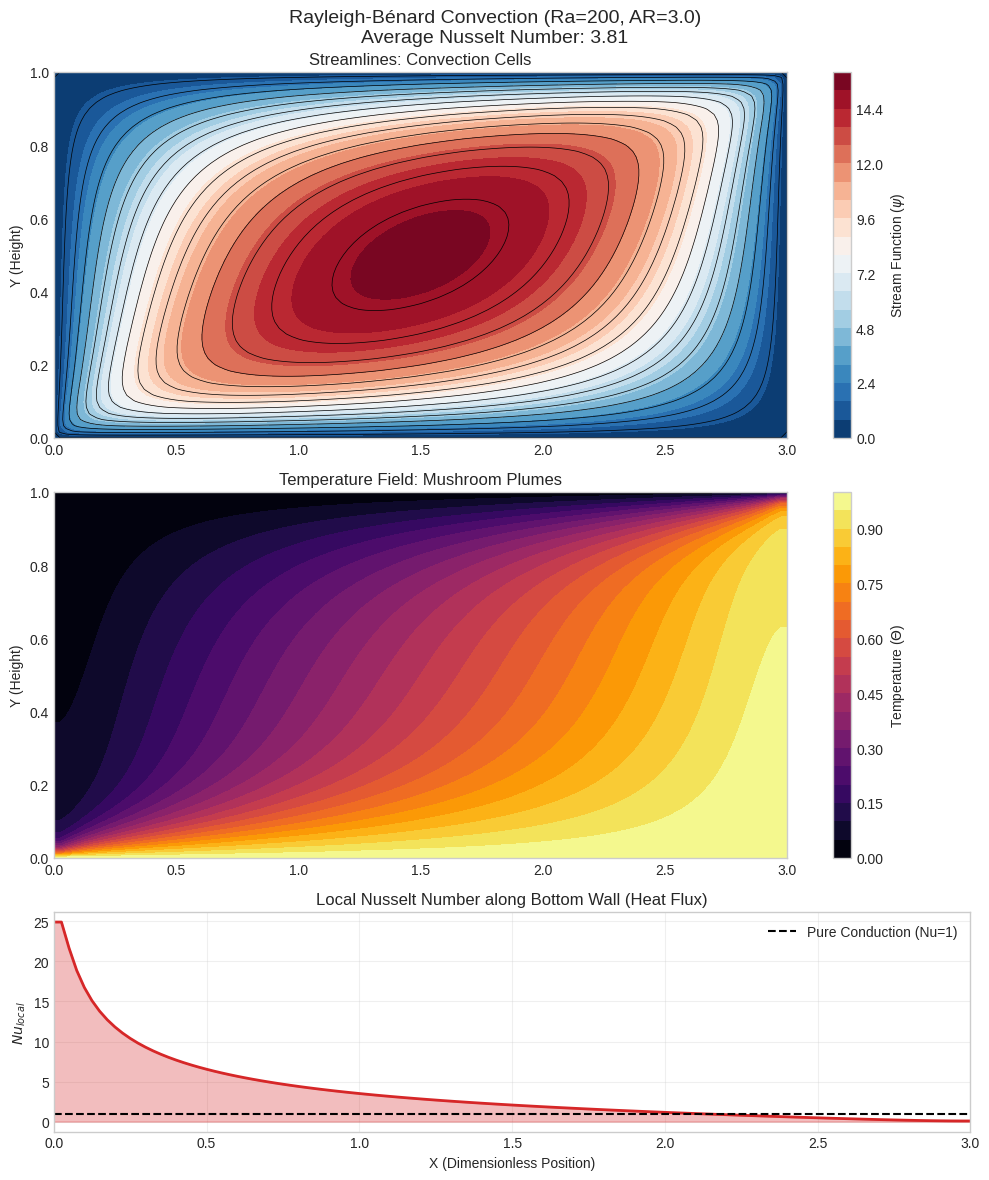

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# --- 1. Specialized Solver for Rayleigh-Bénard (Heated from Below) ---
# =============================================================================
def solve_rb_vectorized(psi, theta, dx, dy, Ra_W, max_iter, tol, urf_psi, urf_theta):
    """
    Specialized solver for Rayleigh-Benard Convection.
    BC changes: 
      - Top/Bottom: Dirichlet (Fixed Temp)
      - Left/Right: Neumann (Adiabatic)
    """
    ny, nx = psi.shape
    
    # Constants
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    inv_2dx = 1.0 / (2.0 * dx)
    inv_2dy = 1.0 / (2.0 * dy)
    geom_factor = 1.0 / (2.0 * (inv_dx2 + inv_dy2))
    
    # Slices for vectorization
    s_c = (slice(1, -1), slice(1, -1))
    s_t = (slice(2, None), slice(1, -1))
    s_b = (slice(0, -2), slice(1, -1))
    s_l = (slice(1, -1), slice(0, -2))
    s_r = (slice(1, -1), slice(2, None))
    
    for it in range(1, max_iter + 1):
        psi_old = psi.copy()
        theta_old = theta.copy()
        
        # --- Derivatives ---
        dpsi_dy = (psi_old[s_t] - psi_old[s_b]) * inv_2dy
        dpsi_dx = (psi_old[s_r] - psi_old[s_l]) * inv_2dx
        dtheta_dy = (theta_old[s_t] - theta_old[s_b]) * inv_2dy
        dtheta_dx = (theta_old[s_r] - theta_old[s_l]) * inv_2dx
        
        # --- Theta Equation ---
        advection = dpsi_dy * dtheta_dx - dpsi_dx * dtheta_dy
        lap_theta = inv_dx2 * (theta_old[s_r] + theta_old[s_l]) + \
                    inv_dy2 * (theta_old[s_t] + theta_old[s_b])
        
        theta_new = geom_factor * (lap_theta - advection)
        theta[s_c] = (1.0 - urf_theta) * theta_old[s_c] + urf_theta * theta_new
        
        # --- Psi Equation (Angle = 0 hardcoded: Buoyancy = -Ra * dtheta_dy) ---
        # Note: sin(0)=0, cos(0)=1 => term is -1 * dtheta_dy
        buoyancy = -Ra_W * dtheta_dy
        
        lap_psi = inv_dx2 * (psi_old[s_r] + psi_old[s_l]) + \
                  inv_dy2 * (psi_old[s_t] + psi_old[s_b])
        
        psi_new = geom_factor * (lap_psi + buoyancy)
        psi[s_c] = (1.0 - urf_psi) * psi_old[s_c] + urf_psi * psi_new
        
        # --- Boundary Conditions (SWAPPED for Rayleigh-Benard) ---
        # 1. Temperature: Bottom=1 (Hot), Top=0 (Cold) -> Fixed
        theta[0, :] = 1.0 
        theta[-1, :] = 0.0
        
        # 2. Temperature Sides: Adiabatic (Copy neighbor)
        theta[:, 0] = theta[:, 1]
        theta[:, -1] = theta[:, -2]
        
        # 3. Psi: All walls 0 (Impermeable) - No update needed

        if it % 1000 == 0:
            if np.max(np.abs(psi - psi_old)) < tol:
                break
                
    return psi, theta

# =============================================================================
# --- 2. Run Case B with Perturbation ---
# =============================================================================
def run_rayleigh_benard(AR, Ra_W):
    NX, NY = 121, 61 # Higher resolution X for rolls
    dx = float(AR) / (NX - 1) # Note: Domain is length AR, height 1
    dy = 1.0 / (NY - 1)
    
    # Init Fields
    psi = np.zeros((NY, NX))
    theta = np.zeros((NY, NX))
    
    # Linear Gradient Initial Condition
    for i in range(NY):
        theta[i, :] = 1.0 - (i / (NY - 1))
        
    # *** CRITICAL: Add Random Noise to trigger instability ***
    np.random.seed(42)
    theta += np.random.normal(0, 0.01, theta.shape)
    
    # Enforce BCs immediately to clean edges
    theta[0, :] = 1.0
    theta[-1, :] = 0.0
    
    # Solve
    psi, theta = solve_rb_vectorized(psi, theta, dx, dy, Ra_W, 20000, 1e-5, 0.9, 0.9)
    return psi, theta

# Run Simulation (Ra=200 for stronger rolls, AR=3 to see multiple cells)
# Using Ra=200 to ensure we are well above critical Ra for porous media (~40)
ar_rb = 3.0
psi_rb, theta_rb = run_rayleigh_benard(AR=ar_rb, Ra_W=200) 

# =============================================================================
#  Visualization ---
# =============================================================================
x = np.linspace(0, ar_rb, psi_rb.shape[1])
y = np.linspace(0, 1, psi_rb.shape[0])
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f"Corrected Case B: Rayleigh-Bénard (Heated from Below)\nRa_W=200, AR={ar_rb}, Angle=0°")

# Temperature
cf = axes[0].contourf(X, Y, theta_rb, levels=20, cmap='hot')
plt.colorbar(cf, ax=axes[0])
axes[0].set_title("Temperature (Mushroom Plumes)")
axes[0].set_aspect('equal')

# Streamlines
axes[1].contour(X, Y, psi_rb, levels=15, colors='k', linewidths=1)
axes[1].set_title("Stream Function (Convection Rolls)")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# =============================================================================
#  Enhanced Visualization with Nusselt Number ---
# =============================================================================
# Grid setup for plotting
x = np.linspace(0, ar_rb, psi_rb.shape[1])
y = np.linspace(0, 1, psi_rb.shape[0])
X, Y = np.meshgrid(x, y)

# --- CALCULATION: Local Nusselt Number at Bottom Wall (y=0) ---
# Definition: Nu = - d(Theta)/dy. 
# Since Theta goes 1 -> 0, the gradient is negative. We want the magnitude of heat flux.
# Using 1st order forward difference: (Theta_wall - Theta_neighbor) / dy
dy_val = 1.0 / (psi_rb.shape[0] - 1)
Nu_local = (theta_rb[0, :] - theta_rb[1, :]) / dy_val
Nu_avg = np.mean(Nu_local)

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 1, 0.6]})
plt.suptitle(f"Rayleigh-Bénard Convection (Ra={200}, AR={ar_rb})\nAverage Nusselt Number: {Nu_avg:.2f}", fontsize=14)

# 1. Stream Function (The Flow)
# Using RdBu_r to distinguish clockwise vs counter-clockwise rolls
c1 = axes[0].contourf(X, Y, psi_rb, levels=20, cmap='RdBu_r')
axes[0].contour(X, Y, psi_rb, levels=15, colors='k', linewidths=0.5)
plt.colorbar(c1, ax=axes[0], label='Stream Function ($\psi$)')
axes[0].set_title("Streamlines: Convection Cells")
axes[0].set_ylabel("Y (Height)")

# 2. Temperature Field (The Heat)
c2 = axes[1].contourf(X, Y, theta_rb, levels=20, cmap='inferno')
plt.colorbar(c2, ax=axes[1], label='Temperature ($\Theta$)')
axes[1].set_title("Temperature Field: Mushroom Plumes")
axes[1].set_ylabel("Y (Height)")

# 3. Local Nusselt Number (The Heat Transfer)
axes[2].plot(x, Nu_local, color='#d62728', linewidth=2)
axes[2].fill_between(x, Nu_local, alpha=0.3, color='#d62728')
axes[2].set_xlim(0, ar_rb)
# Add a dashed line for pure conduction (Nu = 1)
axes[2].axhline(1.0, color='k', linestyle='--', label='Pure Conduction (Nu=1)')
axes[2].set_title("Local Nusselt Number along Bottom Wall (Heat Flux)")
axes[2].set_xlabel("X (Dimensionless Position)")
axes[2].set_ylabel("$Nu_{local}$")
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

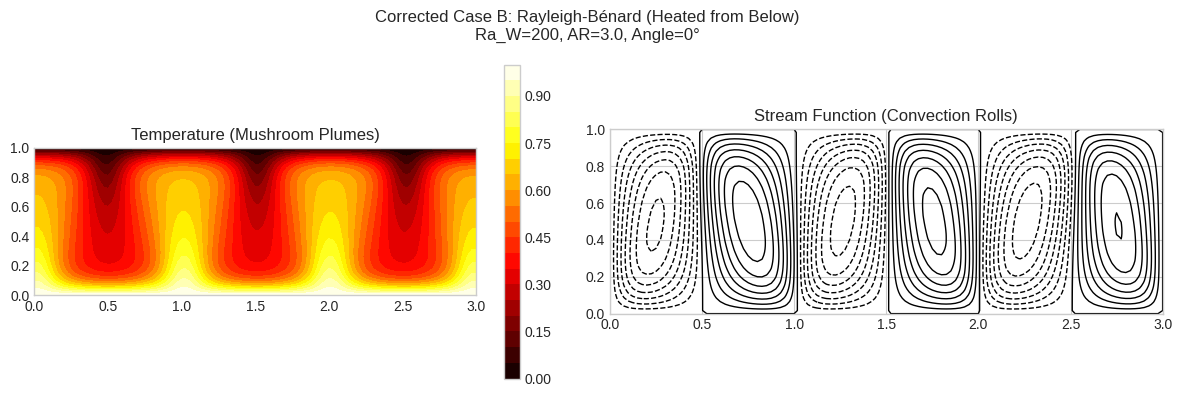

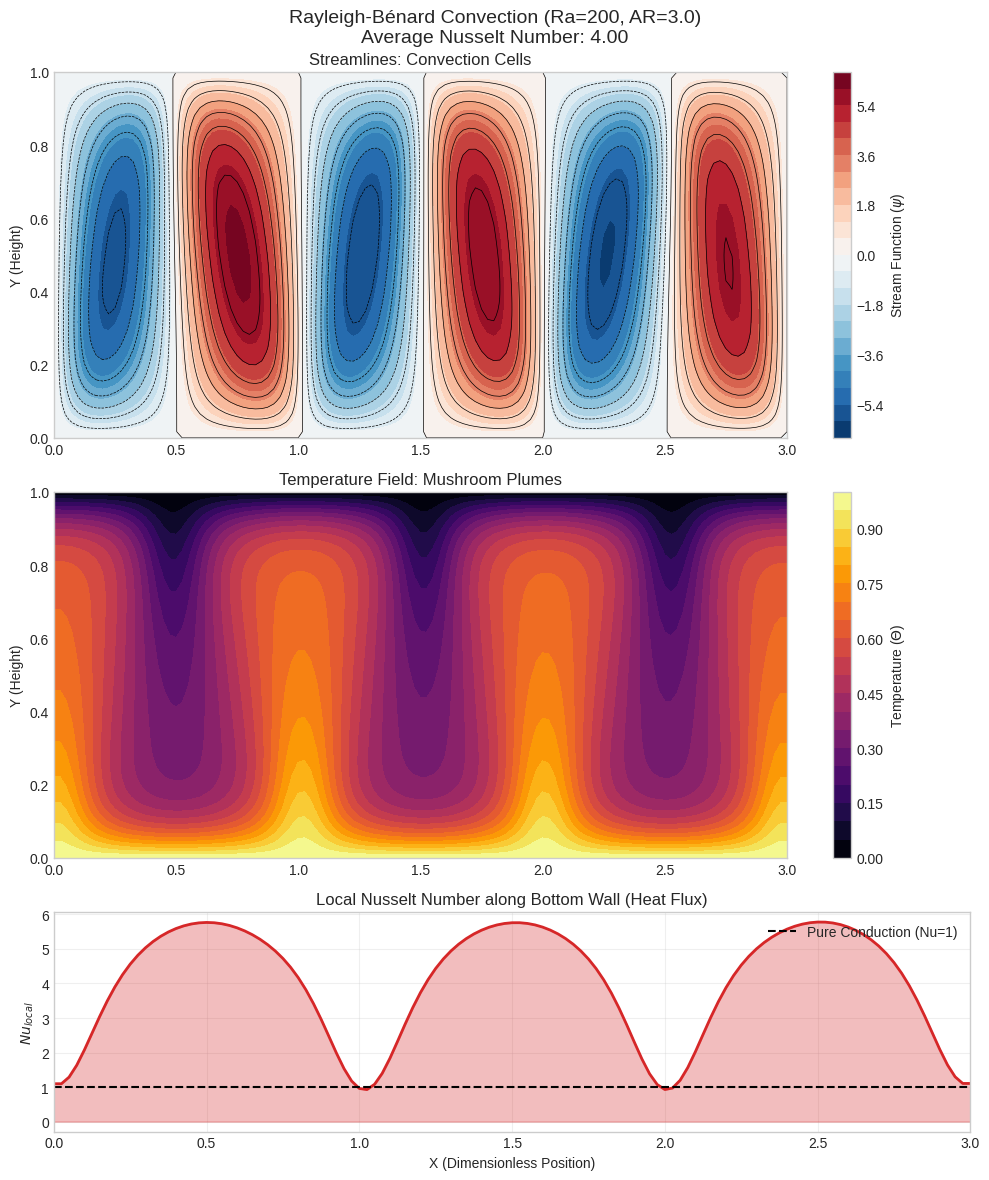

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# --- 1. Specialized Solver for Rayleigh-Bénard (Heated from Below) ---
# =============================================================================
def solve_rb_vectorized(psi, theta, dx, dy, Ra_W, max_iter, tol, urf_psi, urf_theta):
    """
    Specialized solver for Rayleigh-Benard Convection.
    BC changes: 
      - Top/Bottom: Dirichlet (Fixed Temp)
      - Left/Right: Neumann (Adiabatic)
    """
    ny, nx = psi.shape
    
    # Constants
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    inv_2dx = 1.0 / (2.0 * dx)
    inv_2dy = 1.0 / (2.0 * dy)
    geom_factor = 1.0 / (2.0 * (inv_dx2 + inv_dy2))
    
    # Slices for vectorization
    s_c = (slice(1, -1), slice(1, -1))
    s_t = (slice(2, None), slice(1, -1))
    s_b = (slice(0, -2), slice(1, -1))
    s_l = (slice(1, -1), slice(0, -2))
    s_r = (slice(1, -1), slice(2, None))
    
    for it in range(1, max_iter + 1):
        psi_old = psi.copy()
        theta_old = theta.copy()
        
        # --- Derivatives ---
        dpsi_dy = (psi_old[s_t] - psi_old[s_b]) * inv_2dy
        dpsi_dx = (psi_old[s_r] - psi_old[s_l]) * inv_2dx
        dtheta_dy = (theta_old[s_t] - theta_old[s_b]) * inv_2dy
        dtheta_dx = (theta_old[s_r] - theta_old[s_l]) * inv_2dx
        
        # --- Theta Equation ---
        advection = dpsi_dy * dtheta_dx - dpsi_dx * dtheta_dy
        lap_theta = inv_dx2 * (theta_old[s_r] + theta_old[s_l]) + \
                    inv_dy2 * (theta_old[s_t] + theta_old[s_b])
        
        theta_new = geom_factor * (lap_theta - advection)
        theta[s_c] = (1.0 - urf_theta) * theta_old[s_c] + urf_theta * theta_new
        
        # --- Psi Equation (Angle = 0 hardcoded: Buoyancy = -Ra * dtheta_dy) ---
        # Note: sin(0)=0, cos(0)=1 => term is -1 * dtheta_dy
        buoyancy = Ra_W * dtheta_dx
        
        lap_psi = inv_dx2 * (psi_old[s_r] + psi_old[s_l]) + \
                  inv_dy2 * (psi_old[s_t] + psi_old[s_b])
        
        psi_new = geom_factor * (lap_psi + buoyancy)
        psi[s_c] = (1.0 - urf_psi) * psi_old[s_c] + urf_psi * psi_new
        
        # --- Boundary Conditions (SWAPPED for Rayleigh-Benard) ---
        # 1. Temperature: Bottom=1 (Hot), Top=0 (Cold) -> Fixed
        theta[0, :] = 1.0 
        theta[-1, :] = 0.0
        
        # 2. Temperature Sides: Adiabatic (Copy neighbor)
        theta[:, 0] = theta[:, 1]
        theta[:, -1] = theta[:, -2]
        
        # 3. Psi: All walls 0 (Impermeable) - No update needed

        if it % 1000 == 0:
            if np.max(np.abs(psi - psi_old)) < tol:
                break
                
    return psi, theta

# =============================================================================
# --- 2. Run Case B with Perturbation ---
# =============================================================================
def run_rayleigh_benard(AR, Ra_W):
    NX, NY = 121, 61 # Higher resolution X for rolls
    dx = float(AR) / (NX - 1) # Note: Domain is length AR, height 1
    dy = 1.0 / (NY - 1)
    
    # Init Fields
    psi = np.zeros((NY, NX))
    theta = np.zeros((NY, NX))
    
    # Linear Gradient Initial Condition
    for i in range(NY):
        theta[i, :] = 1.0 - (i / (NY - 1))
        
    # *** CRITICAL: Add Random Noise to trigger instability ***
    np.random.seed(42)
    theta += np.random.normal(0, 0.01, theta.shape)
    
    # Enforce BCs immediately to clean edges
    theta[0, :] = 1.0
    theta[-1, :] = 0.0
    
    # Solve
    psi, theta = solve_rb_vectorized(psi, theta, dx, dy, Ra_W, 20000, 1e-5, 0.9, 0.9)
    return psi, theta

# Run Simulation (Ra=200 for stronger rolls, AR=3 to see multiple cells)
# Using Ra=200 to ensure we are well above critical Ra for porous media (~40)
ar_rb = 3.0
psi_rb, theta_rb = run_rayleigh_benard(AR=ar_rb, Ra_W=200) 

# =============================================================================
#  Visualization ---
# =============================================================================
x = np.linspace(0, ar_rb, psi_rb.shape[1])
y = np.linspace(0, 1, psi_rb.shape[0])
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f"Corrected Case B: Rayleigh-Bénard (Heated from Below)\nRa_W=200, AR={ar_rb}, Angle=0°")

# Temperature
cf = axes[0].contourf(X, Y, theta_rb, levels=20, cmap='hot')
plt.colorbar(cf, ax=axes[0])
axes[0].set_title("Temperature (Mushroom Plumes)")
axes[0].set_aspect('equal')

# Streamlines
axes[1].contour(X, Y, psi_rb, levels=15, colors='k', linewidths=1)
axes[1].set_title("Stream Function (Convection Rolls)")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# =============================================================================
#  Enhanced Visualization with Nusselt Number ---
# =============================================================================
# Grid setup for plotting
x = np.linspace(0, ar_rb, psi_rb.shape[1])
y = np.linspace(0, 1, psi_rb.shape[0])
X, Y = np.meshgrid(x, y)

# --- CALCULATION: Local Nusselt Number at Bottom Wall (y=0) ---
# Definition: Nu = - d(Theta)/dy. 
# Since Theta goes 1 -> 0, the gradient is negative. We want the magnitude of heat flux.
# Using 1st order forward difference: (Theta_wall - Theta_neighbor) / dy
dy_val = 1.0 / (psi_rb.shape[0] - 1)
Nu_local = (theta_rb[0, :] - theta_rb[1, :]) / dy_val
Nu_avg = np.mean(Nu_local)

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 1, 0.6]})
plt.suptitle(f"Rayleigh-Bénard Convection (Ra={200}, AR={ar_rb})\nAverage Nusselt Number: {Nu_avg:.2f}", fontsize=14)

# 1. Stream Function (The Flow)
# Using RdBu_r to distinguish clockwise vs counter-clockwise rolls
c1 = axes[0].contourf(X, Y, psi_rb, levels=20, cmap='RdBu_r')
axes[0].contour(X, Y, psi_rb, levels=15, colors='k', linewidths=0.5)
plt.colorbar(c1, ax=axes[0], label='Stream Function ($\psi$)')
axes[0].set_title("Streamlines: Convection Cells")
axes[0].set_ylabel("Y (Height)")

# 2. Temperature Field (The Heat)
c2 = axes[1].contourf(X, Y, theta_rb, levels=20, cmap='inferno')
plt.colorbar(c2, ax=axes[1], label='Temperature ($\Theta$)')
axes[1].set_title("Temperature Field: Mushroom Plumes")
axes[1].set_ylabel("Y (Height)")

# 3. Local Nusselt Number (The Heat Transfer)
axes[2].plot(x, Nu_local, color='#d62728', linewidth=2)
axes[2].fill_between(x, Nu_local, alpha=0.3, color='#d62728')
axes[2].set_xlim(0, ar_rb)
# Add a dashed line for pure conduction (Nu = 1)
axes[2].axhline(1.0, color='k', linestyle='--', label='Pure Conduction (Nu=1)')
axes[2].set_title("Local Nusselt Number along Bottom Wall (Heat Flux)")
axes[2].set_xlabel("X (Dimensionless Position)")
axes[2].set_ylabel("$Nu_{local}$")
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Compiling JIT functions (this takes a moment)...
Simulation Complete.


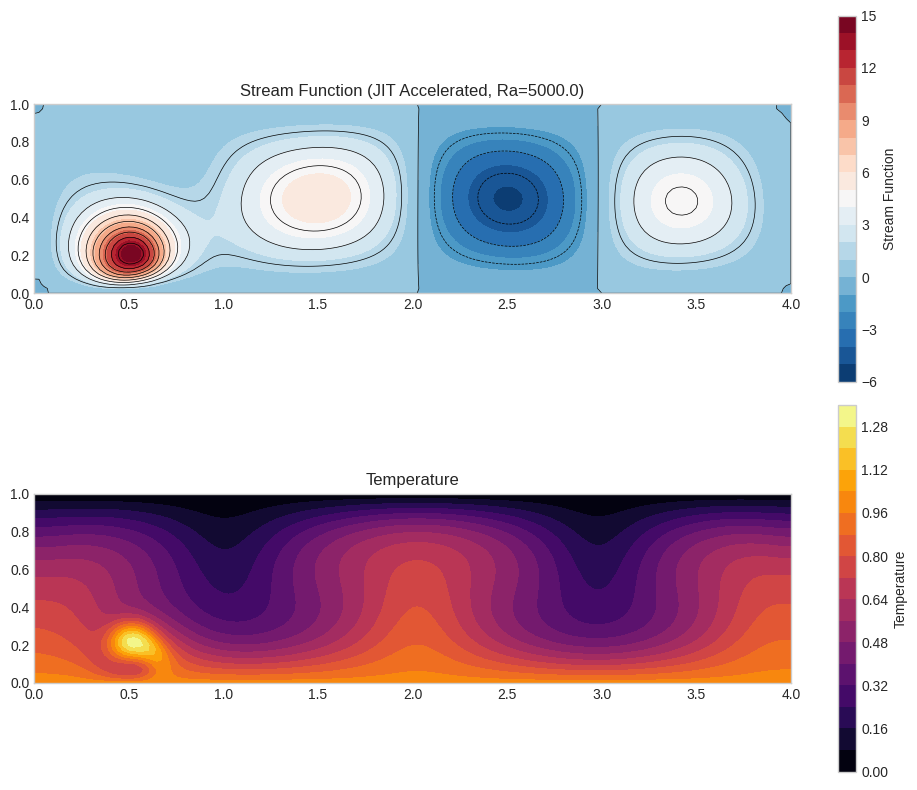

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# =============================================================================
# --- Helper Functions (JIT Compiled) ---
# =============================================================================

@njit
def apply_theta_bc_numba(th):
    """Enforce Temperature BCs: Fixed Top/Bottom, Adiabatic Sides"""
    # Top/Bottom
    th[0, :]  = 1.0
    th[-1, :] = 0.0
    # Sides (Adiabatic / Neumann)
    th[:, 0]  = th[:, 1]
    th[:, -1] = th[:, -2]

@njit
def solve_poisson_psi_numba(ps, om, inv_dx2, inv_dy2, denom, poisson_iters):
    """
    Solves ∇²ψ = -ω for Streamfunction using Jacobi Iteration.
    """
    ny, nx = ps.shape
    # Enforce BCs (psi=0 on walls) strictly before starting
    ps[0, :] = 0.0; ps[-1, :] = 0.0
    ps[:, 0] = 0.0; ps[:, -1] = 0.0

    # Jacobi Iteration
    for _ in range(poisson_iters):
        # We use a temporary array to store the new values (Jacobi style)
        # Using explicit loops is often faster in Numba than slicing
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                rhs = -om[j, i]
                ps[j, i] = (inv_dx2 * (ps[j, i+1] + ps[j, i-1]) + 
                            inv_dy2 * (ps[j+1, i] + ps[j-1, i]) - rhs) / denom
    return ps

@njit
def apply_wall_vorticity_numba(om, ps, inv_dx2, inv_dy2):
    """
    Thom's Boundary Condition for Vorticity at no-slip walls.
    ω_wall = -2 * ψ_neighbor / d_perp²
    """
    ny, nx = om.shape
    
    # Bottom Wall (j=0), neighbor is j=1
    for i in range(1, nx - 1):
        om[0, i] = -2.0 * ps[1, i] * inv_dy2
        
    # Top Wall (j=ny-1), neighbor is j=ny-2
    for i in range(1, nx - 1):
        om[ny-1, i] = -2.0 * ps[ny-2, i] * inv_dy2
        
    # Left Wall (i=0), neighbor is i=1
    for j in range(1, ny - 1):
        om[j, 0] = -2.0 * ps[j, 1] * inv_dx2
        
    # Right Wall (i=nx-1), neighbor is i=nx-2
    for j in range(1, ny - 1):
        om[j, -1] = -2.0 * ps[j, -2] * inv_dx2
        
    # Corners (Average of neighbors)
    om[0, 0]     = 0.5 * (om[0, 1] + om[1, 0])
    om[0, -1]    = 0.5 * (om[0, -2] + om[1, -1])
    om[-1, 0]    = 0.5 * (om[-1, 1] + om[-2, 0])
    om[-1, -1]   = 0.5 * (om[-1, -2] + om[-2, -1])

@njit
def upwind_advection_numba(phi, u, v, inv_dx, inv_dy):
    """
    Calculates u*dphi/dx + v*dphi/dy using First-Order Upwinding.
    Returns the advection term at interior points.
    """
    ny, nx = phi.shape
    adv = np.zeros((ny, nx))
    
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            # Upwind dphi/dx
            vel_u = u[j, i]
            if vel_u > 0:
                dphi_dx = (phi[j, i] - phi[j, i-1]) * inv_dx
            else:
                dphi_dx = (phi[j, i+1] - phi[j, i]) * inv_dx
                
            # Upwind dphi/dy
            vel_v = v[j, i]
            if vel_v > 0:
                dphi_dy = (phi[j, i] - phi[j-1, i]) * inv_dy
            else:
                dphi_dy = (phi[j+1, i] - phi[j, i]) * inv_dy
            
            adv[j, i] = vel_u * dphi_dx + vel_v * dphi_dy
            
    return adv

# =============================================================================
# --- Main Solver (JIT Compiled) ---
# =============================================================================

@njit
def rb_solve_fast(AR, NX, NY, Ra, Pr, nsteps, poisson_iters, dt_max, cfl, tol):
    # Grid setup
    dx = AR / (NX - 1)
    dy = 1.0 / (NY - 1)
    inv_dx = 1.0 / dx
    inv_dy = 1.0 / dy
    inv_dx2 = inv_dx**2
    inv_dy2 = inv_dy**2
    inv_2dx = 0.5 * inv_dx
    inv_2dy = 0.5 * inv_dy
    denom = 2.0 * (inv_dx2 + inv_dy2)

    # Initialization
    psi = np.zeros((NY, NX))
    omega = np.zeros((NY, NX))
    theta = np.zeros((NY, NX))
    
    # Initial Condition: Linear gradient + Noise
    for j in range(NY):
        y_val = j * dy
        for i in range(NX):
            x_val = i * dx
            # 1.0 at bottom, 0.0 at top
            theta[j, i] = 1.0 - y_val 
            # Add perturbation
            theta[j, i] += 0.01 * np.sin(4 * np.pi * x_val / AR) * np.sin(np.pi * y_val)

    apply_theta_bc_numba(theta)

    # Pre-allocate arrays for derivatives to save memory alloc in loop
    u = np.zeros((NY, NX))
    v = np.zeros((NY, NX))
    lap_theta = np.zeros((NY, NX))
    lap_omega = np.zeros((NY, NX))

    # --- Time Loop ---
    for n in range(1, nsteps + 1):
        psi_prev = psi.copy()

        # 1. Calculate Velocities (Centered Difference)
        # u = dpsi/dy, v = -dpsi/dx
        for j in range(1, NY - 1):
            for i in range(1, NX - 1):
                u[j, i] = (psi[j+1, i] - psi[j-1, i]) * inv_2dy
                v[j, i] = -(psi[j, i+1] - psi[j, i-1]) * inv_2dx

        # 2. Adaptive Time Step (CFL)
        max_u = 0.0
        max_v = 0.0
        for j in range(NY):
            for i in range(NX):
                max_u = max(max_u, abs(u[j,i]))
                max_v = max(max_v, abs(v[j,i]))
        
        dt = dt_max
        if max_u > 1e-8: dt = min(dt, cfl * dx / max_u)
        if max_v > 1e-8: dt = min(dt, cfl * dy / max_v)
        
        # 3. Calculate Laplacians (Diffusion)
        for j in range(1, NY - 1):
            for i in range(1, NX - 1):
                lap_theta[j, i] = (theta[j, i+1] - 2*theta[j, i] + theta[j, i-1])*inv_dx2 + \
                                  (theta[j+1, i] - 2*theta[j, i] + theta[j-1, i])*inv_dy2
                lap_omega[j, i] = (omega[j, i+1] - 2*omega[j, i] + omega[j, i-1])*inv_dx2 + \
                                  (omega[j+1, i] - 2*omega[j, i] + omega[j-1, i])*inv_dy2

        # 4. Calculate Advection (Upwind)
        adv_theta = upwind_advection_numba(theta, u, v, inv_dx, inv_dy)
        adv_omega = upwind_advection_numba(omega, u, v, inv_dx, inv_dy)

        # 5. Update Equations
        for j in range(1, NY - 1):
            for i in range(1, NX - 1):
                # Buoyancy Source: Ra * Pr * dTheta/dx
                # (Standard Centered Difference for Source term is fine/better)
                dtheta_dx_src = (theta[j, i+1] - theta[j, i-1]) * inv_2dx
                
                # Theta Equation
                theta[j, i] = theta[j, i] + dt * (lap_theta[j, i] - adv_theta[j, i])
                
                # Vorticity Equation
                omega[j, i] = omega[j, i] + dt * (Pr * lap_omega[j, i] - adv_omega[j, i] + Ra * Pr * dtheta_dx_src)

        # 6. BCs and Solvers
        apply_theta_bc_numba(theta)
        
        # Solve Streamfunction (Iterative Poisson)
        psi = solve_poisson_psi_numba(psi, omega, inv_dx2, inv_dy2, denom, poisson_iters)
        
        # Update Wall Vorticity
        apply_wall_vorticity_numba(omega, psi, inv_dx2, inv_dy2)

        # Convergence Check (every 1000 steps)
        if n % 2000 == 0:
            diff = 0.0
            for j in range(NY):
                for i in range(NX):
                    diff = max(diff, abs(psi[j, i] - psi_prev[j, i]))
            if diff < tol:
                print("Converged at step", n)
                break
                
    return psi, theta

# =============================================================================
# --- Driver Script ---
# =============================================================================

# Parameters
AR = 4.0
NX = 161
NY = 41
Ra = 5000.0  # Increased Ra for stronger convection cells
Pr = 1.0
nsteps = 100000
poisson_iters = 50  # Can be lower since we warm-start from previous step
dt_max = 5e-4
cfl = 0.3
tol = 1e-6

print("Compiling JIT functions (this takes a moment)...")
# First run includes compilation time
psi, theta = rb_solve_fast(AR, NX, NY, Ra, Pr, nsteps, poisson_iters, dt_max, cfl, tol)
print("Simulation Complete.")

# =============================================================================
# --- Visualization ---
# =============================================================================
x = np.linspace(0, AR, NX)
y = np.linspace(0, 1, NY)
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Streamlines
cf1 = axes[0].contourf(X, Y, psi, levels=20, cmap='RdBu_r')
axes[0].contour(X, Y, psi, levels=15, colors='k', linewidths=0.5)
plt.colorbar(cf1, ax=axes[0], label='Stream Function')
axes[0].set_title(f"Stream Function (JIT Accelerated, Ra={Ra})")
axes[0].set_aspect('equal')

# Temperature
cf2 = axes[1].contourf(X, Y, theta, levels=20, cmap='inferno')
plt.colorbar(cf2, ax=axes[1], label='Temperature')
axes[1].set_title("Temperature")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

Starting Porous Media Simulation (Ra=200.0)...
Step 0, Max Change: 0.132271
Step 1000, Max Change: 0.000226
Step 2000, Max Change: 0.000042
Step 3000, Max Change: 0.000034
Step 4000, Max Change: 0.000028
Step 5000, Max Change: 0.000024
Step 6000, Max Change: 0.000022
Step 7000, Max Change: 0.000020
Step 8000, Max Change: 0.000018
Step 9000, Max Change: 0.000016


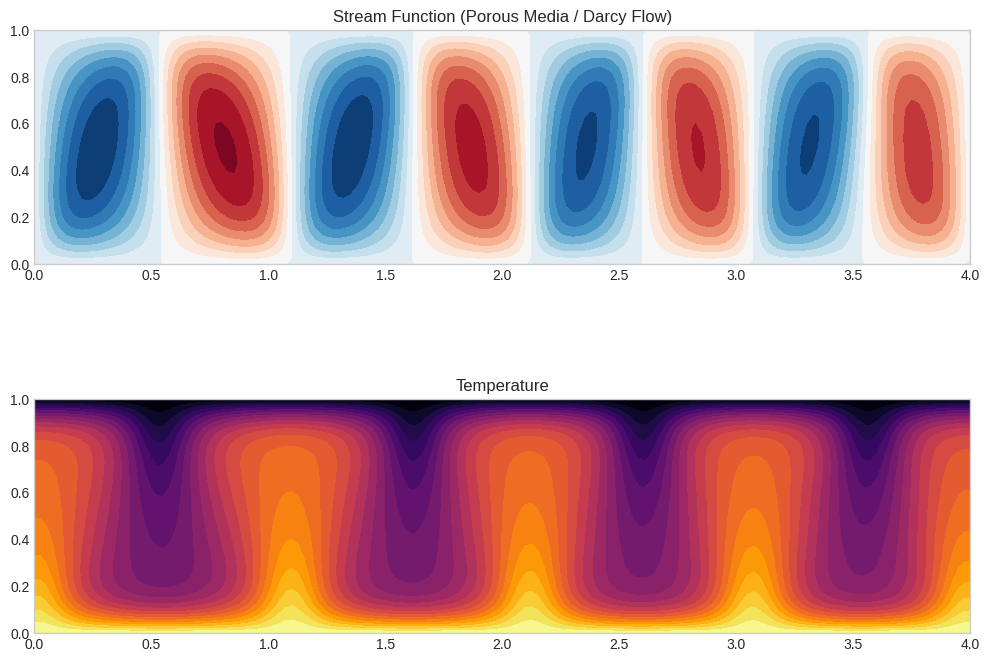

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def solve_darcy_benard(AR=4.0, Ra=200.0, nx=161, ny=41, max_steps=10000):
    """
    Solves Darcy-Benard Convection (Porous Media).
    Physics:
      - Flow is governed by Darcy's Law (No Inertia, No Viscosity term).
      - Psi is determined instantly by Temperature gradient.
      - Equation: del^2(psi) = -Ra * dT/dx
    """
    dx = AR / (nx - 1)
    dy = 1.0 / (ny - 1)
    
    # Precompute constants for the Poisson solver
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    denom = 2.0 * (inv_dx2 + inv_dy2)
    
    # --- 1. Initialization ---
    # psi is streamfunction, theta is temperature
    psi = np.zeros((ny, nx))
    theta = np.zeros((ny, nx))
    
    # Linear gradient (Hot bottom, Cold top)
    y = np.linspace(0, 1, ny)
    for i in range(ny):
        theta[i, :] = 1.0 - y[i]
        
    # *** CRITICAL: Add Random Noise to trigger instability ***
    # Porous media is very stable; it needs a kick to start convection.
    np.random.seed(42)
    theta += 0.05 * np.random.randn(ny, nx)
    
    # Enforce BCs immediately (T=1 bottom, T=0 top)
    theta[0, :] = 1.0
    theta[-1, :] = 0.0
    theta[:, 0] = theta[:, 1]   # Adiabatic Left
    theta[:, -1] = theta[:, -2] # Adiabatic Right

    # Slices for vectorization
    s_c = (slice(1, -1), slice(1, -1))
    s_l = (slice(1, -1), slice(0, -2))
    s_r = (slice(1, -1), slice(2, None))
    s_b = (slice(0, -2), slice(1, -1))
    s_t = (slice(2, None), slice(1, -1))

    # Time stepping parameters
    dt = 0.0001 # Small timestep for stability
    
    print(f"Starting Porous Media Simulation (Ra={Ra})...")
    
    for step in range(max_steps):
        theta_old = theta.copy()
        
        # --- 2. Solve Flow (Darcy's Law) ---
        # Equation: Laplacian(psi) = -Ra * dtheta/dx
        # We solve this iteratively (SOR/Jacobi)
        # In Porous Media, this happens INSTANTLY at every step.
        
        # Calculate Buoyancy Term: -Ra * dtheta/dx
        # (Using centered difference)
        dtheta_dx = (theta_old[s_r] - theta_old[s_l]) / (2.0 * dx)
        rhs = -Ra * dtheta_dx
        
        # Fast relaxation to solve for Psi
        # We run a few internal iterations to align Psi with the new Theta
        for _ in range(50): 
            psi_new = (inv_dx2 * (psi[s_r] + psi[s_l]) + 
                       inv_dy2 * (psi[s_t] + psi[s_b]) - rhs) / denom
            psi[s_c] = psi_new
            # Enforce Psi=0 on boundaries (Impermeable walls)
            psi[0,:]=0; psi[-1,:]=0; psi[:,0]=0; psi[:,-1]=0

        # --- 3. Update Temperature (Advection + Diffusion) ---
        # Calculate Velocity from Psi
        # u = dpsi/dy, v = -dpsi/dx
        u = (psi[s_t] - psi[s_b]) / (2.0 * dy)
        v = -(psi[s_r] - psi[s_l]) / (2.0 * dx)
        
        # Calculate Gradients of Theta
        dt_dx = (theta_old[s_r] - theta_old[s_l]) / (2.0 * dx)
        dt_dy = (theta_old[s_t] - theta_old[s_b]) / (2.0 * dy)
        
        # Advection Term: u*dT/dx + v*dT/dy
        advection = u * dt_dx + v * dt_dy
        
        # Diffusion Term: Laplacian(Theta)
        diffusion = inv_dx2 * (theta_old[s_r] - 2*theta_old[s_c] + theta_old[s_l]) + \
                    inv_dy2 * (theta_old[s_t] - 2*theta_old[s_c] + theta_old[s_b])
        
        # Update Theta
        theta[s_c] = theta_old[s_c] + dt * (diffusion - advection)
        
        # Re-enforce BCs
        theta[0, :] = 1.0; theta[-1, :] = 0.0
        theta[:, 0] = theta[:, 1]; theta[:, -1] = theta[:, -2]

        # Check convergence
        if step % 1000 == 0:
            change = np.max(np.abs(theta - theta_old))
            print(f"Step {step}, Max Change: {change:.6f}")
            if change < 1e-6:
                print("Converged!")
                break
                
    return psi, theta

# --- Run Simulation ---
# Ra=200 is sufficient for Porous Media (Critical Ra is 4*pi^2 approx 40)
psi_pm, theta_pm = solve_darcy_benard(AR=4.0, Ra=200.0, max_steps=10000)

# --- Visualization ---
x = np.linspace(0, 4.0, psi_pm.shape[1])
y = np.linspace(0, 1, psi_pm.shape[0])
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].contourf(X, Y, psi_pm, levels=20, cmap='RdBu_r')
axes[0].set_title("Stream Function (Porous Media / Darcy Flow)")
axes[0].set_aspect('equal')

axes[1].contourf(X, Y, theta_pm, levels=20, cmap='inferno')
axes[1].set_title("Temperature")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()